In [4]:
from dotenv import load_dotenv


load_dotenv()
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

## Working shitty version

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


[HumanMessage(content=[{'type': 'text', 'text': '\nDescribe the picture.\nGiven the current state of the analysis and the given photo reason about the location of a photo.\nTry to get as many accurate and relevant information as possible.\n'}, {'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={}, id='7f690c8e-5b3b-4610-beb5-c605c2f92a09'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'country_prediction', 'arguments': '{"query": ""}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}
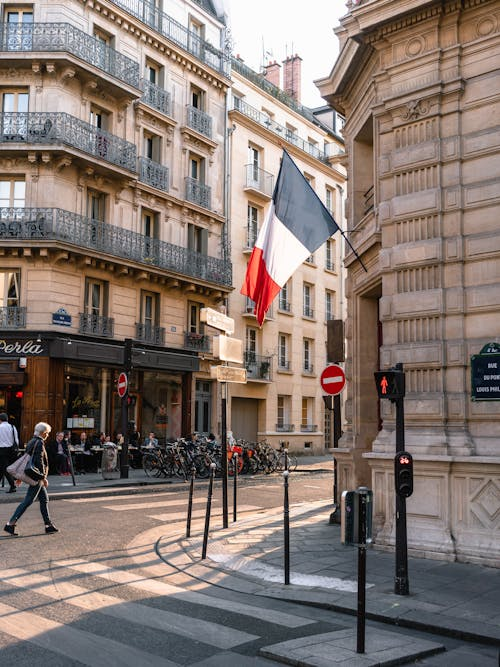

In [65]:
from typing import Annotated, Literal, TypedDictsss

from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel
from typing import Dict, List, Any
import json
import base64
import pprint

@tool
def country_prediction(query: str):
    """Predicts the country where the photo was taken."""
    return "France"


tools = [country_prediction]

tool_node = ToolNode(tools)

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

from pydantic import BaseModel, Field

class Location(BaseModel):
    """Location of an photo with reasoning."""

    latitude: str = Field(description="The latitude of the location")
    longitude: str = Field(description="The longitude of the location")
    reasoning: str = Field(description="Reasoning about the location of the photo")

def should_continue(state: MessagesState):
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "end"

def call_model(state: MessagesState):
    messages = state['messages']
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def generate_final_coordinates(state: MessagesState):
    messages = state['messages']
    structured_model = model.with_structured_output(Location)
    response = structured_model.invoke(messages)
    return {"messages": [str(response.model_dump_json())]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("final_location", generate_final_coordinates)

workflow.add_edge(START, "agent")
workflow.add_edge("tools", 'agent')
workflow.add_conditional_edges("agent", should_continue, {"tools": "tools", "end": "final_location"})
workflow.add_edge("final_location", END)

app = workflow.compile()

image = open("test2.jpg", "rb").read()
image_data = base64.b64encode(image).decode("utf-8")
prompt = f"""
Describe the picture.
Given the current state of the analysis and the given photo reason about the location of a photo.
Try to get as many accurate and relevant information as possible.
"""
message = HumanMessage(
    content=[
        {"type": "text", "text": prompt},
        {"type": "image_url", "image_url": {"url":  f"data:image/jpeg;base64,{image_data}"}},
    ],
)



In [66]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


================================ Human Message =================================

[{'type': 'text', 'text': '\nDescribe the picture.\nGiven the current state of the analysis and the given photo reason about the location of a photo.\nTry to get as many accurate and relevant information as possible.\n'}, {'type': 'image_url', 'image_url': {'url': ''}}]

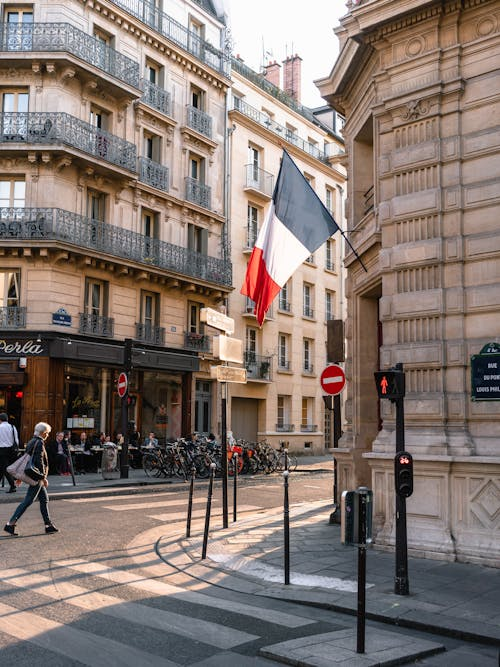

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


================================== Ai Message ==================================
Tool Calls:
  country_prediction (e157a078-f136-40df-8622-7cea8f78c594)
 Call ID: e157a078-f136-40df-8622-7cea8f78c594
  Args:
    query:
================================= Tool Message =================================
Name: country_prediction

France
================================== Ai Message ==================================

The photo shows a street corner in France. There is a French flag flying, a cafe called "Perla", and a sign that says "Rue Duperre, Louis Phill". It looks like a typical Parisian street.
================================ Human Message =================================

{"latitude":"48.8566","longitude":"2.3522","reasoning":"The photo shows a street corner in France. There is a French flag flying, a cafe called \"Perla\", and a sign that says \"Rue Duperre, Louis Phill\". It looks like a typical Parisian street."}


In [67]:
print_stream(app.stream({"messages": [message]}, stream_mode="values"))

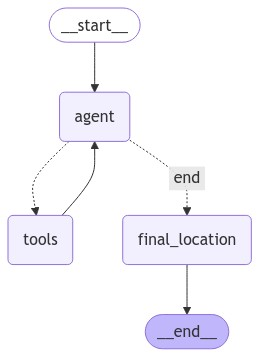

In [64]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))
